In [ ]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split


: 

In [29]:
df = pd.read_csv('./data/processed_data.csv')
df.shape


(18471, 69)

In [30]:
df_caregiver = pd.read_csv('data/processed_caregiver_data.csv', header=0)
df_caregiver.shape

(14221, 6)

In [31]:
# Final labels
labels = ['patientState_good', 'patientState_caution', 'patientState_danger']
# Section labels
section_labels = {
    'fever': ['feverState_good', 'feverState_caution', 'feverState_danger'],
    'medication': ['medicationState_good', 'medicationState_caution', 'medicationState_danger'],
    'hydration': ['hydrationState_good', 'hydrationState_caution', 'hydrationState_danger'],
    'respiration': ['respirationState_good', 'respirationState_caution', 'respirationState_danger'],
    'skin': ['skinState_good', 'skinState_caution', 'skinState_danger'],
    'pulse': ['pulseState_good', 'pulseState_caution', 'pulseState_danger'],
    'general': ['generalState_good', 'generalState_caution', 'generalState_danger'],
}

caregiver_labels = ['caregiverState_good', 'caregiverState_caution', 'caregiverState_danger']
caregiver_features = ['caregiverFeel', 'caregiverThink', 'caregiverConfident']

section_features = {
    'fever': ['ageInMonths', 'temperature', 'feverDuration'],
    'medication': [
        'antibiotics',
        'antibioticsHowMany',
        'antibioticsHowMuch',
        'antipyretic',
        'antipyreticHowMany',
        'antipyreticHowMuch'],
    'hydration': [
        'crying',
        'diarrhea',
        'drinking',
        'lastUrination',
        'skinTurgor',
        'tearsWhenCrying',
        'tongue',
        'vomit-01-No', 'vomit-02-Slight', 'vomit-03-Frequent', 'vomit-04-Yellow', 'vomit-05-5<hours'],
    'respiration': [
        'dyspnea',
        'respiratoryRate',
        'wheezing',
        'ageInMonths'],
    'skin': ['glassTest', 'rash', 'skinColor'],
    'pulse': ['pulse', 'ageInMonths'],
    'general': [
        'awareness-01-Normal', 'awareness-02-SleepyOddOrFeverishNightmares', 'awareness-03-NoReactionsNoAwareness',
        'bulgingFontanelleMax18MOld',
        'exoticTrip',
        'lastTimeEating',
        'pain-01-No', 'pain-02-FeelingBad', 'pain-03-Headache', 'pain-04-SwollenPainful', 'pain-05-StrongBellyacheAche',
        'painfulUrination',
        'seizure',
        'smellyUrine',
        'vaccinationIn14days',
        'vaccinationHowManyHoursAgo',
        'wryNeck'],
}
# Section labels in an array flattened
section_labels_arr = [item for val in section_labels.values() for item in val]
# All labels
all_labels = [*labels, *section_labels_arr]


In [32]:
# Separating to testing and training

# Prepare the data: You should split your data into training and test sets.
# The training set will be used to train the model and the test set will be used
# to evaluate the model's performance.
def split(dataset, ground_truth, test_size=0.2, val_size=0.2):
    _x, x_test, _y, y_test = train_test_split(
        dataset.to_numpy(),
        ground_truth.to_numpy(),
        test_size=test_size,
        random_state=42
    )
    x_train, x_val, y_train, y_val = train_test_split(
        _x,
        _y,
        test_size=val_size / 0.8,
        random_state=42
    )
    return x_train, np.argmax(y_train, axis=1), x_val, np.argmax(y_val, axis=1), x_test, np.argmax(y_test, axis=1)


In [33]:
import tensorflow_decision_forests as tfdf


In [72]:
def create_model(tuner):
    model = tfdf.keras.RandomForestModel(verbose=0, tuner=tuner)
    model.compile(metrics=['accuracy'])
    return model


In [73]:
models = {}
model_results = {}

In [138]:
def train_model(X, Y, name, tuner = None):
    x_train, y_train, x_val, y_val, x_test, y_test = split(X, Y)
    model = create_model(tuner)
    model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), verbose=0)

    loss, acc = model.evaluate(x=x_test, y=y_test, verbose=0)

    model_results[name] = [acc]

    models[name] = model
    print(model.summary())


In [139]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)
tuner.choice("num_candidate_attributes_ratio", [1.0, 0.8, 0.6])
tuner.choice('num_trees', [150, 300, 450, 600])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [8,16,32,64])

global_search_space = tuner.choice(
    "growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

In [140]:
for key in section_features.keys():
    train_model(
        df[section_features[key]],
        df[section_labels[key]],
        key,
        tuner
    )


# ----------------------------- CAREGIVER SECTION ---------------------------- #
train_model(
    df_caregiver[caregiver_features],
    df_caregiver[caregiver_labels],
    'caregiver',
    tuner
)



Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


2023-03-06 23:05:20.917021: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_611"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (3):
	data:0.0
	data:0.1
	data:0.2

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.2"  1.000000 ################
    2. "data:0.1"  0.358760 
    3. "data:0.0"  0.330473 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.2" 300.000000 

Variable Importance: NUM_NODES:
    1. "data:0.0" 13155.000000 ################
    2. "data:0.1" 5391.000000 ######
    3. "data:0.2" 600.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.2" 898106.459554 ################
    2. "data:0.1" 497297.720312 ##
    3. "data:0.0" 434082.819831 


Hyperparameter optimizer:

Best parameters: num_candidate_attributes_ratio:0

2023-03-06 23:05:40.648729: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_612"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	data:0.0
	data:0.1
	data:0.2
	data:0.3
	data:0.4
	data:0.5

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.3"  1.000000 ################
    2. "data:0.1"  0.379507 #
    3. "data:0.0"  0.361073 #
    4. "data:0.2"  0.342924 
    5. "data:0.5"  0.320114 
    6. "data:0.4"  0.316572 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.3" 300.000000 

Variable Importance: NUM_NODES:
    1. "data:0.0" 300.000000 ################
    2. "data:0.3" 300.000000 ################
    3. "data:0.1" 202.000000 ##########
    4. "data:0.2" 171.000000 ########
    5. "data:0.5" 51.000000 
    6. "data:0.4" 38.0000

2023-03-06 23:05:47.775835: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_613"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.2"  0.695915 ################
    2.  "data:0.5"  0.288247 ####
    3.  "data:0.8"  0.248077 ###
    4.  "data:0.0"  0.207176 ##
    5.  "data:0.3"  0.178131 #
    6. "data:0.11"  0.155548 
    7.  "data:0.1"  0.150611 
    8.  "data:0.9"  0.149028 
    9.  "data:0.4"  0.145037 
   10.  "data:0.6"  0.135998 
   11. "data:0.10"  0.135207 
   12.  "data:0.7"  0.132294 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.2" 438.000000 #

2023-03-06 23:06:21.722325: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_614"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	data:0.0
	data:0.1
	data:0.2
	data:0.3

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.2"  1.000000 ################
    2. "data:0.0"  0.462622 #####
    3. "data:0.1"  0.331172 ##
    4. "data:0.3"  0.200357 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.2" 450.000000 

Variable Importance: NUM_NODES:
    1. "data:0.3" 93052.000000 ################
    2. "data:0.1" 51377.000000 ########
    3. "data:0.0" 3792.000000 
    4. "data:0.2" 900.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.1" 830799.762302 ################
    2. "data:0.3" 667818.493551 ###########
    3. "data:0.2" 6386

2023-03-06 23:06:53.326346: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_615"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (3):
	data:0.0
	data:0.1
	data:0.2

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.2"  1.000000 ################
    2. "data:0.1"  0.354890 
    3. "data:0.0"  0.334200 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.2" 300.000000 

Variable Importance: NUM_NODES:
    1. "data:0.2" 600.000000 ################
    2. "data:0.0" 586.000000 ###############
    3. "data:0.1" 314.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.2" 732478.903771 ################
    2. "data:0.1" 403415.353390 ########
    3. "data:0.0" 44690.401855 


Hyperparameter optimizer:

Best parameters: num_candidate_attribu

2023-03-06 23:06:58.145213: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_616"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	data:0.0
	data:0.1

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.0"  1.000000 ################
    2. "data:0.1"  0.314786 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 450.000000 

Variable Importance: NUM_NODES:
    1. "data:0.1" 79537.000000 ################
    2. "data:0.0" 48898.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.0" 777099.244167 ################
    2. "data:0.1" 712365.721765 


Hyperparameter optimizer:

Best parameters: num_candidate_attributes_ratio:1 num_trees:450 growing_strategy:LOCAL max_depth:16
Num steps: 20
Best score: 0.949016

Step #0 score:0.932232

2023-03-06 23:07:25.871327: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_617"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (17):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.6"  0.487246 ################
    2.  "data:0.9"  0.230002 ####
    3.  "data:0.5"  0.213152 ###
    4. "data:0.10"  0.194571 ###
    5.  "data:0.1"  0.189676 ##
    6. "data:0.16"  0.181547 ##
    7. "data:0.12"  0.179487 ##
    8.  "data:0.8"  0.151772 #
    9.  "data:0.7"  0.149179 #
   10. "data:0.13"  0.142293 
   11.  "data:0.0"  0.139783 
   12.  "data:0.3"  0.129078 
  

2023-03-06 23:08:13.284579: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_618"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (3):
	data:0.0
	data:0.1
	data:0.2

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.0"  1.000000 ################
    2. "data:0.1"  0.342371 
    3. "data:0.2"  0.328145 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 300.000000 

Variable Importance: NUM_NODES:
    1. "data:0.2" 1387.000000 ################
    2. "data:0.1" 645.000000 
    3. "data:0.0" 600.000000 

Variable Importance: SUM_SCORE:
    1. "data:0.0" 1904009.645846 ################
    2. "data:0.1" 605597.998718 ####
    3. "data:0.2" 75890.279689 


Hyperparameter optimizer:

Best parameters: num_candidate_attributes_ratio:1 num_t

In [141]:
# -------------------------------- ALL DATASET ------------------------------- #
# Using the whole dataset with a decision forest

train_model(
    df.drop(columns=all_labels),
    df[labels],
    'all',
    tuner
)



Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


2023-03-06 23:08:25.090892: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:208] Hyperparameter search space:
fields {
  name: "num_candidate_attributes_ratio"
  discrete_candidates {
    possible_values {
      real: 1
    }
    possible_values {
      real: 0.8
    }
    possible_values {
      real: 0.6
    }
  }
}
fields {
  name: "num_trees"
  discrete_candidates {
    possible_values {
      integer: 150
    }
    possible_values {
      integer: 300
    }
    possible_values {
      integer: 450
    }
    possible_values {
      integer: 600
    }
  }
}
fields {
  name: "growing_strategy"
  discrete_candidates {
    possible_values {
      categorical: "LOCAL"
    }
    possible_values {
      categorical: "BEST_FIRST_GLOBAL"
    }
  }
  children {
    name: "max_depth"
    discrete_candidates {
      possible_values {
        integer: 8
      }
      possible_values {
        integer: 16
      }
      possible_values {
  

Model: "random_forest_model_619"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (45):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.30
	data:0.31
	data:0.32
	data:0.33
	data:0.34
	data:0.35
	data:0.36
	data:0.37
	data:0.38
	data:0.39
	data:0.4
	data:0.40
	data:0.41
	data:0.42
	data:0.43
	data:0.44
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.6"  1.000000 ################
    2.  "data:0.1"  0.218624 ##
    3.  "d

In [142]:
import matplotlib.pyplot as plt

hyperparam_res = {}
for key, model in models.items():
    tuning_logs = model.make_inspector().tuning_logs()
    hyperparam_res[key] = dict(tuning_logs[tuning_logs.best].iloc[0])


df_hyperparam_res = pd.DataFrame(hyperparam_res)
df_hyperparam_res


,fever,medication,hydration,respiration,skin,pulse,general,caregiver,all
score,0.995849,0.999459,0.99621,0.943963,1.0,0.949016,0.994586,0.998828,0.944234
evaluation_time,5.87264,1.480695,16.945802,14.605912,0.997984,24.935046,18.280771,1.360759,128.579645
best,True,True,True,True,True,True,True,True,True
num_candidate_attributes_ratio,0.6,1.0,0.6,1.0,1.0,1.0,0.6,1.0,1.0
num_trees,300,300,600,450,300,450,150,300,450
growing_strategy,LOCAL,BEST_FIRST_GLOBAL,BEST_FIRST_GLOBAL,LOCAL,BEST_FIRST_GLOBAL,LOCAL,BEST_FIRST_GLOBAL,BEST_FIRST_GLOBAL,LOCAL
max_num_nodes,NaN,32.0,256.0,NaN,32.0,NaN,256.0,32.0,NaN
max_depth,32.0,NaN,NaN,64.0,NaN,16.0,NaN,NaN,64.0


In [143]:
def create_model_from_hyperparams(hp):
    model = tfdf.keras.RandomForestModel(
        verbose=0,
        growing_strategy=hp['growing_strategy'] if pd.notna(hp['growing_strategy']) else None,
        max_num_nodes=int(hp['max_num_nodes']) if pd.notna(hp['max_num_nodes']) else None,
        max_depth=int(hp['max_depth']) if pd.notna(hp['max_depth']) else None)
    model.compile(metrics=['accuracy'])
    return model

In [144]:
model_results

{'fever': [0.9967523813247681],
 'medication': [0.9991880655288696],
 'hydration': [0.9959404468536377],
 'respiration': [0.9510148763656616],
 'skin': [1.0],
 'pulse': [0.9512855410575867],
 'general': [0.9967523813247681],
 'caregiver': [0.999297022819519],
 'all': [0.950203001499176]}

In [145]:
from sklearn.model_selection import KFold

n_split = 10


def cross_validate(X, Y, hp):
    results = []
    for train_index, test_index in KFold(n_split).split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        model = create_model_from_hyperparams(hp)
        model.fit(x_train, y_train, verbose=0)

        loss, acc = model.evaluate(x_test, y_test, verbose=0)
        results.append(acc)
    return results


In [146]:
cross_results = {}
for key in section_features.keys():
    print('================', key, '================')
    cross_validate_result = cross_validate(
        df[section_features[key]].to_numpy(),
        np.argmax(df[section_labels[key]].to_numpy(), axis=1),
        df_hyperparam_res[key]
    )
    cross_results[key] = cross_validate_result

print('================', 'caregiver', '================')
cross_validate_result = cross_validate(
    df_caregiver[caregiver_features].to_numpy(),
    np.argmax(df_caregiver[caregiver_labels].to_numpy(), axis=1),
    df_hyperparam_res['caregiver']
)
cross_results['caregiver'] = cross_validate_result

print('================', 'all', '================')
cross_validate_result = cross_validate(
    df.drop(columns=all_labels).to_numpy(),
    np.argmax(df[labels].to_numpy(), axis=1),
    df_hyperparam_res['all']
)
cross_results['all'] = cross_validate_result


================ fever ================


[INFO 2023-03-06T23:13:29.567394089+01:00 kernel.cc:1214] Loading model from path /tmp/tmpd1x_ukl7/model/ with prefix 456f88a94b96421c
[INFO 2023-03-06T23:13:29.683599943+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 50176 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:13:29.683630547+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T23:13:29.683645937+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:13:31.417272213+01:00 kernel.cc:1214] Loading model from path /tmp/tmpxiuv7a0r/model/ with prefix 01ee1f9e022d4b55
[INFO 2023-03-06T23:13:31.530264158+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 48038 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:13:31.53030602+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:13:33.28015439+01:00 kernel.cc:1214] Loading model from path /tmp/tmpph_bjz38/model/ with prefix 7c9c0e1aa0d64d93
[INFO 2023-03-06T23:13:33.393870216+01:00 decision_forest.cc

================ medication ================


[INFO 2023-03-06T23:13:46.724342245+01:00 kernel.cc:1214] Loading model from path /tmp/tmpuyi72l8l/model/ with prefix 42a7ce047ed941ff
[INFO 2023-03-06T23:13:46.734666332+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4376 node(s), and 6 input feature(s).
[INFO 2023-03-06T23:13:46.734693117+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:13:47.628675972+01:00 kernel.cc:1214] Loading model from path /tmp/tmpcyn0ryds/model/ with prefix be7a1c700a164ac9
[INFO 2023-03-06T23:13:47.639047811+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4146 node(s), and 6 input feature(s).
[INFO 2023-03-06T23:13:47.639093105+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:13:50.045305192+01:00 kernel.cc:1214] Loading model from path /tmp/tmpxk1vxc1x/model/ with prefix 0d914e10958e490a
[INFO 2023-03-06T23:13:50.059801425+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4290 node(s), and 6 input feature(s).
[INFO 2023-03-06T23:13:50.

================ hydration ================


[INFO 2023-03-06T23:13:58.312952707+01:00 kernel.cc:1214] Loading model from path /tmp/tmpftue26al/model/ with prefix dd251fd85d0d4b40
[INFO 2023-03-06T23:13:58.389159354+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30792 node(s), and 12 input feature(s).
[INFO 2023-03-06T23:13:58.389191803+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:00.337795477+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8tmfowit/model/ with prefix c2e8f20874d44229
[INFO 2023-03-06T23:14:00.419004212+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31340 node(s), and 12 input feature(s).
[INFO 2023-03-06T23:14:00.419040466+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:02.356655306+01:00 kernel.cc:1214] Loading model from path /tmp/tmps740ge1v/model/ with prefix c2d8bccc8606407b
[INFO 2023-03-06T23:14:02.436319391+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31356 node(s), and 12 input feature(s).
[INFO 2023-03-06T23:

================ respiration ================


[INFO 2023-03-06T23:14:18.495683366+01:00 kernel.cc:1214] Loading model from path /tmp/tmp5b28zke8/model/ with prefix b79341e8afba42c5
[INFO 2023-03-06T23:14:19.101759968+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 260660 node(s), and 4 input feature(s).
[INFO 2023-03-06T23:14:19.101793449+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:21.510776356+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2xx0oql3/model/ with prefix c8f641cbae62490c
[INFO 2023-03-06T23:14:22.169662393+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 270124 node(s), and 4 input feature(s).
[INFO 2023-03-06T23:14:22.169695719+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:24.54817616+01:00 kernel.cc:1214] Loading model from path /tmp/tmpt2mtmj2_/model/ with prefix 91507449135c493a
[INFO 2023-03-06T23:14:25.167554481+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 269464 node(s), and 4 input feature(s).
[INFO 2023-03-06T23:1

================ skin ================


[INFO 2023-03-06T23:14:47.685129466+01:00 kernel.cc:1214] Loading model from path /tmp/tmp10_n6b83/model/ with prefix a1d7b15a7e3b4941
[INFO 2023-03-06T23:14:47.692670788+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3302 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:14:47.692714851+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T23:14:47.692727926+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:48.483172984+01:00 kernel.cc:1214] Loading model from path /tmp/tmpt051hnb4/model/ with prefix 6efa017bbe6e49b2
[INFO 2023-03-06T23:14:48.490387705+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3300 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:14:48.490425148+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:49.222441186+01:00 kernel.cc:1214] Loading model from path /tmp/tmpojg6gaqc/model/ with prefix 1116b0c20a9f463d
[INFO 2023-03-06T23:14:49.229367153+01:00 decision_forest.cc

================ pulse ================


[INFO 2023-03-06T23:14:56.289968229+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2tfvtxxj/model/ with prefix 183a7d0d1c044f0e
[INFO 2023-03-06T23:14:56.841528084+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 234604 node(s), and 2 input feature(s).
[INFO 2023-03-06T23:14:56.84156362+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:14:58.889769614+01:00 kernel.cc:1214] Loading model from path /tmp/tmpj2u8bjp9/model/ with prefix 9b61850de66841c7
[INFO 2023-03-06T23:14:59.425393516+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 233858 node(s), and 2 input feature(s).
[INFO 2023-03-06T23:14:59.425422477+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T23:14:59.425437423+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:15:01.441792458+01:00 kernel.cc:1214] Loading model from path /tmp/tmpft70gij4/model/ with prefix 57d9f125904a4222
[INFO 2023-03-06T23:15:01.978924204+01:00 decision_forest

================ general ================


[INFO 2023-03-06T23:15:22.200886577+01:00 kernel.cc:1214] Loading model from path /tmp/tmp3q9_x583/model/ with prefix 9e9d98bac703475f
[INFO 2023-03-06T23:15:22.270370866+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28500 node(s), and 17 input feature(s).
[INFO 2023-03-06T23:15:22.270403211+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:15:24.511064082+01:00 kernel.cc:1214] Loading model from path /tmp/tmpc9p5ty1e/model/ with prefix 143fa62dd59d414a
[INFO 2023-03-06T23:15:24.581168986+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29394 node(s), and 17 input feature(s).
[INFO 2023-03-06T23:15:24.581213115+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:15:26.777638915+01:00 kernel.cc:1214] Loading model from path /tmp/tmp_jxucl80/model/ with prefix c3b564d8d96d4a71
[INFO 2023-03-06T23:15:26.844627836+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28498 node(s), and 17 input feature(s).
[INFO 2023-03-06T23:

================ caregiver ================


[INFO 2023-03-06T23:15:44.923045738+01:00 kernel.cc:1214] Loading model from path /tmp/tmp9f4pqjex/model/ with prefix 903fe71a9c3b40b1
[INFO 2023-03-06T23:15:44.936380401+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5086 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:15:44.93641495+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:15:45.699563689+01:00 kernel.cc:1214] Loading model from path /tmp/tmpdgljazn6/model/ with prefix a044c16004f54b5a
[INFO 2023-03-06T23:15:45.712096387+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5088 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:15:45.712139218+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:15:46.472482875+01:00 kernel.cc:1214] Loading model from path /tmp/tmp6qt065n8/model/ with prefix 275b899c0f404e84
[INFO 2023-03-06T23:15:46.487994775+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5152 node(s), and 3 input feature(s).
[INFO 2023-03-06T23:15:46.4

================ all ================


[INFO 2023-03-06T23:15:59.095399314+01:00 kernel.cc:1214] Loading model from path /tmp/tmpugoiltb9/model/ with prefix 71b051ac54024a37
[INFO 2023-03-06T23:16:00.1621312+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 366052 node(s), and 45 input feature(s).
[INFO 2023-03-06T23:16:00.162162582+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T23:16:00.162180461+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:16:08.403878366+01:00 kernel.cc:1214] Loading model from path /tmp/tmpwla2bgb2/model/ with prefix baa2f2c07ffa4575
[INFO 2023-03-06T23:16:09.383156598+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 362036 node(s), and 44 input feature(s).
[INFO 2023-03-06T23:16:09.38319623+01:00 kernel.cc:1046] Use fast generic engine
[INFO 2023-03-06T23:16:17.10464717+01:00 kernel.cc:1214] Loading model from path /tmp/tmpp1sj1b_x/model/ with prefix 25d8233c5f984880
[INFO 2023-03-06T23:16:18.082930471+01:00 decision_forest.

In [147]:
results = {}

for key, val in cross_results.items():
    avg = sum(val) / len(val)
    results[key] = [avg*100]
results

df_result = pd.DataFrame(results, index=['Accuracy'])
df_result

,fever,medication,hydration,respiration,skin,pulse,general,caregiver,all
Accuracy,99.621021,99.956688,99.756384,94.082723,99.994586,94.445333,99.447818,99.943742,94.396593


In [149]:
for key, model in models.items():
    print('Saving model', key)
    model.save('model/'+key)



Saving model fever


Saving model medication


Saving model hydration


Saving model respiration


Saving model skin


Saving model pulse


Saving model general


Saving model caregiver


Saving model all


In [41]:
plot = tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)
len(plot)


16754

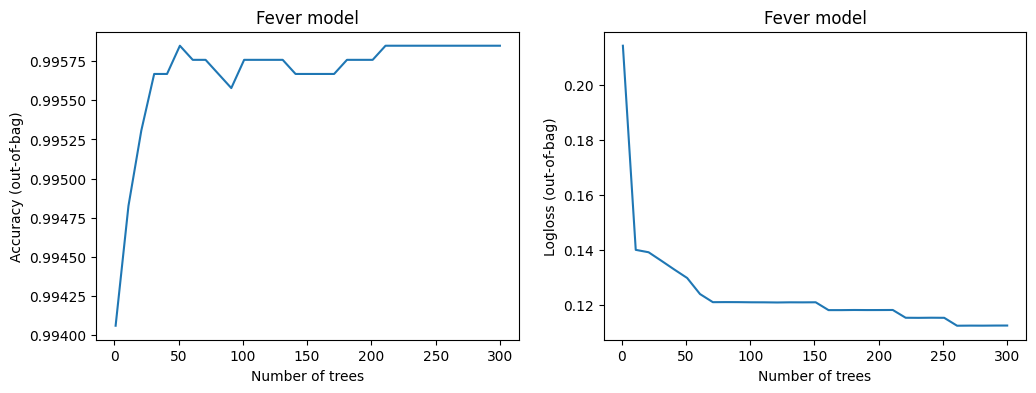

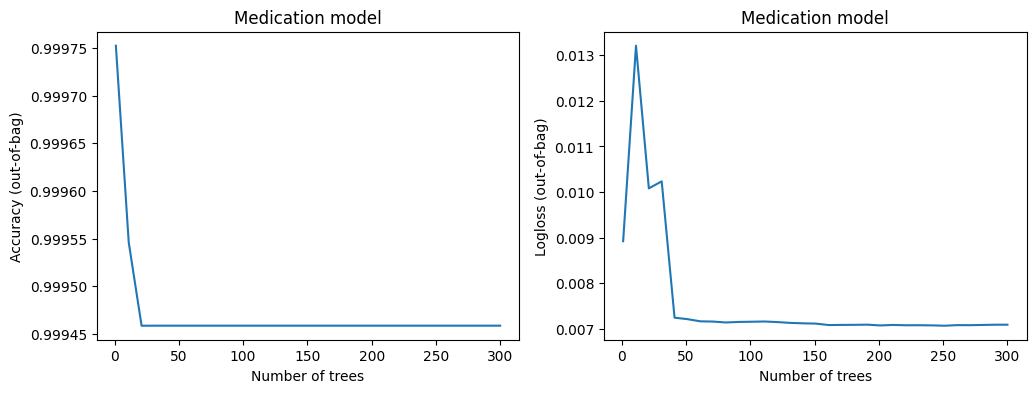

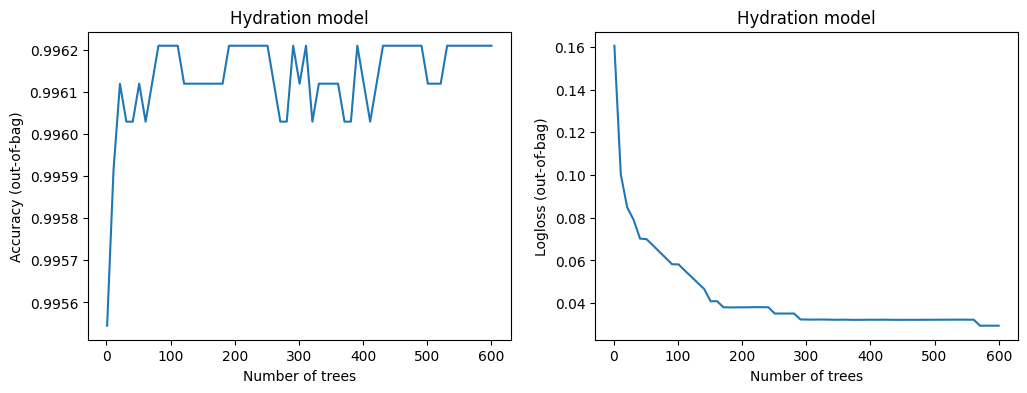

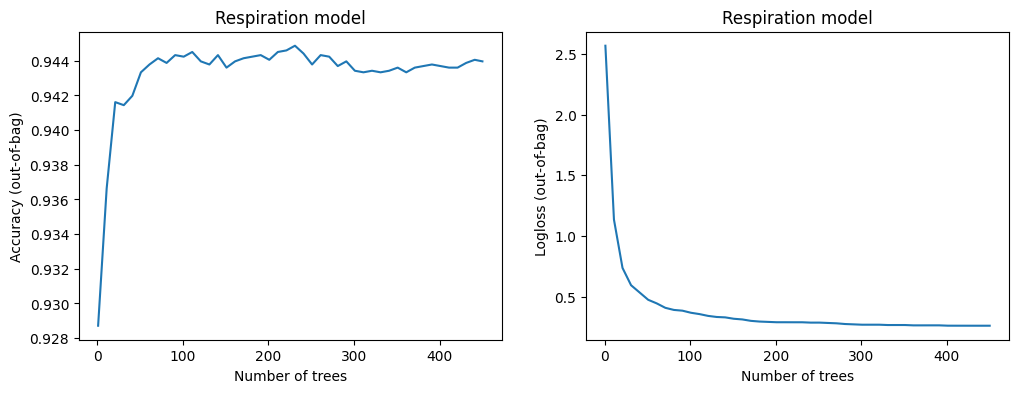

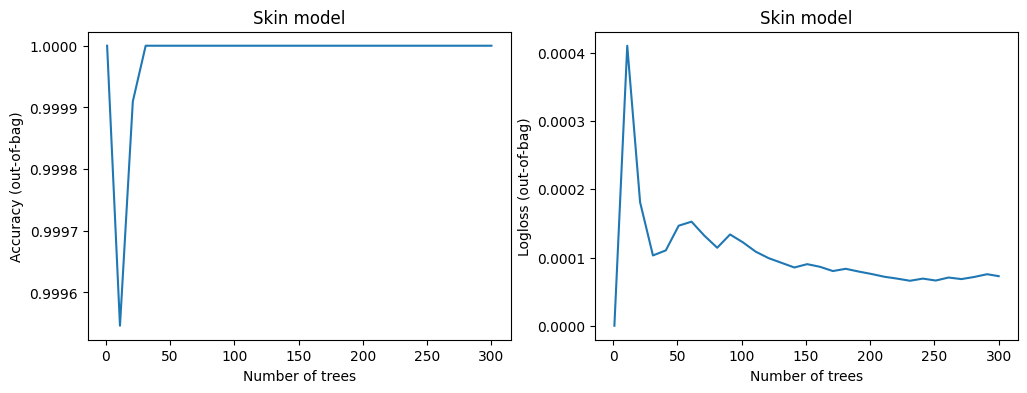

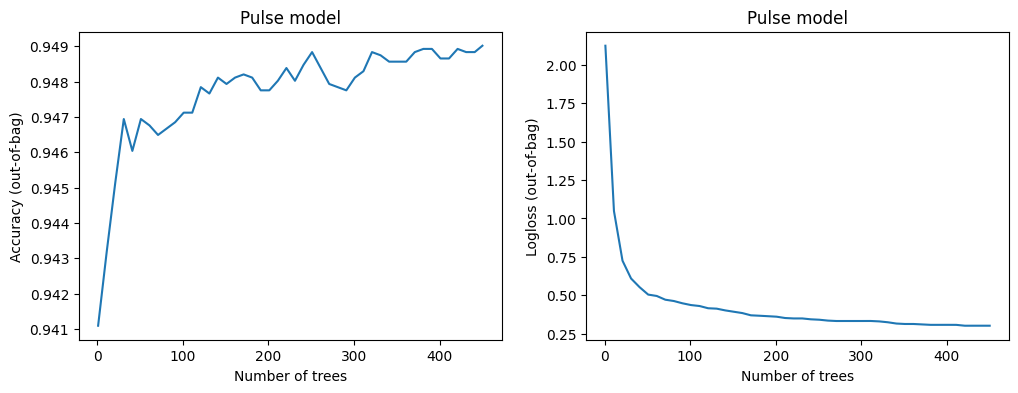

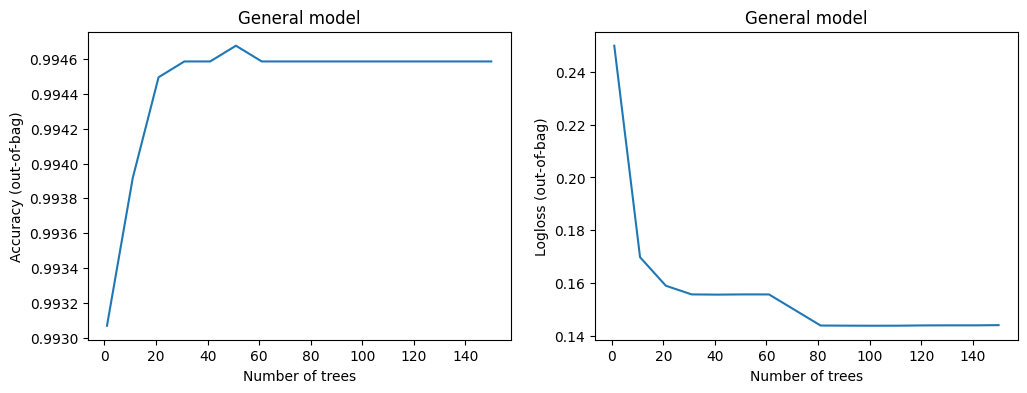

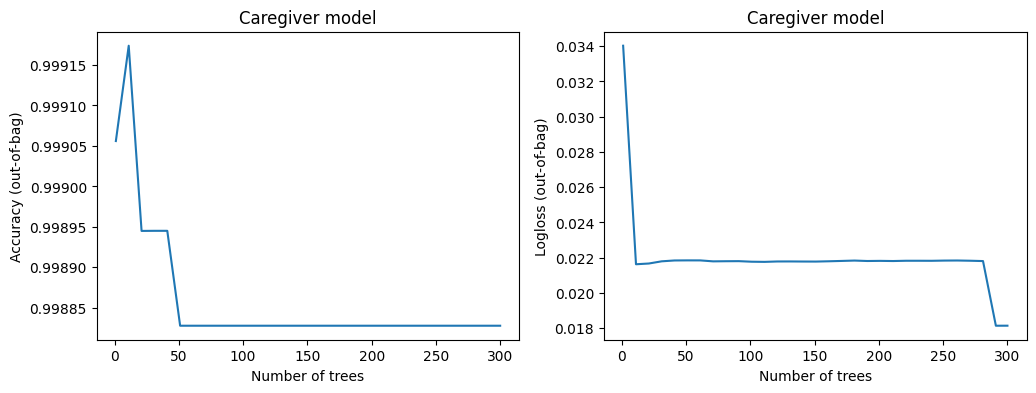

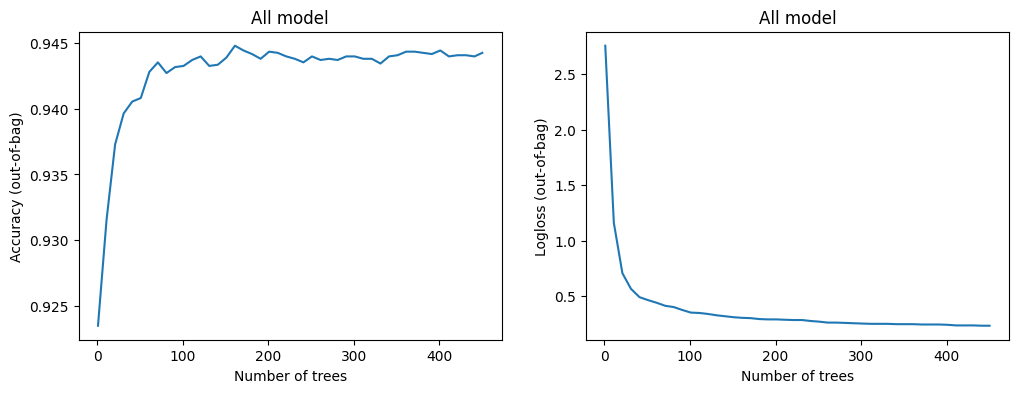

In [148]:
import matplotlib.pyplot as plt

for key, model in models.items():
    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
        log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
        log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()
